کد مربوط به مقاله ارسالی درخصوص تبدیل لایه‌های طبقه‌بند تمام متصل به پیچشی

M. Amintoosi

In [1]:
'''Trains a simple convnet on the HODA dataset.
'''

from __future__ import print_function
import keras
# from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import utils
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cv2
from os.path import isfile, join
import math
import os

# tf.random.set_seed(3)

In [2]:
!pip install pycm
from pycm import *

     |████████████████████████████████| 66 kB 2.4 MB/s 
     |████████████████████████████████| 583 kB 8.6 MB/s 


In [3]:
!git clone https://github.com/mamintoosi/FC2FC.git
%cd FC2FC
import FC2FC

Cloning into 'FC2FC'...
remote: Enumerating objects: 4084, done.
remote: Counting objects: 100% (4084/4084), done.
remote: Compressing objects: 100% (4036/4036), done.
remote: Total 4084 (delta 88), reused 4034 (delta 42), pack-reused 0
Receiving objects: 100% (4084/4084), 63.84 MiB | 14.09 MiB/s, done.
Resolving deltas: 100% (88/88), done.
/content/FC2FC


In [4]:
data_dir = 'data/'
models_dir = 'models/'

# input image dimensions
img_rows, img_cols = 26, 26
inputImSize = 26
num_classes = 10

In [5]:
hodaPath = os.path.join(data_dir, 'Data_hoda_full.mat')
hoda = scipy.io.loadmat(hodaPath)

data = hoda['Data'].reshape(-1)

In [6]:
data_resized = np.array([cv2.resize(img, dsize=(inputImSize, inputImSize)) for img in data])
data = np.expand_dims(data_resized, axis=3)
labels = hoda['labels'].reshape(-1)

In [7]:
# the data, split between train and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data,labels,random_state=1,test_size=0.1)

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)


x_train shape: (54000, 26, 26, 1)
54000 train samples
6000 test samples


In [8]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    zoom_range=0.2,
    validation_split=0.1)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train)


In [9]:
model = FC2FC.seq_model_hoda(inputImSize)
model.summary()

Model: "seqModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 24, 24, 32)        320       
                                                                 
 MaxPool1 (MaxPooling2D)     (None, 12, 12, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 10, 10, 64)        18496     
                                                                 
 MaxPool2 (MaxPooling2D)     (None, 5, 5, 64)          0         
                                                                 
 Conv3 (Conv2D)              (None, 3, 3, 128)         73856     
                                                                 
 MaxPool3 (MaxPooling2D)     (None, 1, 1, 128)         0         
                                                                 
 Flatten1 (Flatten)          (None, 128)               0  

In [10]:
mdl = 'models/best_model.h5'
checkpoint = ModelCheckpoint(filepath=mdl, 
                             monitor='val_loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]
tf.random.set_seed(1)

In [11]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy']
              )

In [12]:
%%time
# fits the model on batches with real-time data augmentation:
epochs = 10
history = model.fit(datagen.flow(x_train, y_train,
                              batch_size=128,
                              subset='training'),
                    validation_data=datagen.flow(x_train, y_train,
                              batch_size=128,
                              subset='validation'),
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/10
380/380 [==============================] - 30s 48ms/step - loss: 0.2732 - accuracy: 0.9136 - val_loss: 0.1267 - val_accuracy: 0.9578
Epoch 2/10
380/380 [==============================] - 28s 75ms/step - loss: 0.0951 - accuracy: 0.9678 - val_loss: 0.0956 - val_accuracy: 0.9694
Epoch 3/10
380/380 [==============================] - 15s 39ms/step - loss: 0.0692 - accuracy: 0.9777 - val_loss: 0.0728 - val_accuracy: 0.9761
Epoch 4/10
380/380 [==============================] - 19s 49ms/step - loss: 0.0551 - accuracy: 0.9823 - val_loss: 0.0674 - val_accuracy: 0.9791
Epoch 5/10
380/380 [==============================] - 21s 54ms/step - loss: 0.0471 - accuracy: 0.9844 - val_loss: 0.0599 - val_accuracy: 0.9804
Epoch 6/10
380/380 [==============================] - 16s 42ms/step - loss: 0.0421 - accuracy: 0.9863 - val_loss: 0.0588 - val_accuracy: 0.9831
Epoch 7/10
380/380 [==============================] - 15s 39ms/step - loss: 0.0369 - accuracy: 0.9874 - val_loss: 0.0593 - val_accuracy:

In [13]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.625570058822632
Test accuracy: 0.9835000038146973


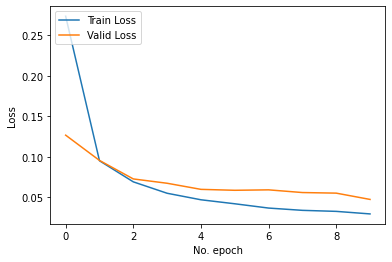

In [14]:
# Plot history: MAE
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Valid Loss')
# plt.title('MAE')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [21]:
model.summary()

Model: "seqModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 24, 24, 32)        320       
                                                                 
 MaxPool1 (MaxPooling2D)     (None, 12, 12, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 10, 10, 64)        18496     
                                                                 
 MaxPool2 (MaxPooling2D)     (None, 5, 5, 64)          0         
                                                                 
 Conv3 (Conv2D)              (None, 3, 3, 128)         73856     
                                                                 
 MaxPool3 (MaxPooling2D)     (None, 1, 1, 128)         0         
                                                                 
 Flatten1 (Flatten)          (None, 128)               0  

In [22]:
convModel = FC2FC.convert_model_hoda(model,mdl,[160,268])
convModel.summary()

Model: "FullyConv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 158, 266, 32)      320       
                                                                 
 MaxPool1 (MaxPooling2D)     (None, 79, 133, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 77, 131, 64)       18496     
                                                                 
 MaxPool2 (MaxPooling2D)     (None, 38, 65, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 36, 63, 128)       73856     
                                                                 
 MaxPool3 (MaxPooling2D)     (None, 18, 31, 128)       0         
                                                                 
 lastConv (Conv2D)           (None, 18, 31, 10)        12

In [16]:
!ls -hs models

total 1.2M
1.2M best_model.h5


In [143]:
# تست یک تصویر شامل چندین نمونه 
# fileName = 'data/persian-digits2.jpg' 
fileName = '../Riazi_Haftom.jpg' 
# fileName = 'data/Asaadi.jpg' 
img = image.load_img(fileName,color_mode='grayscale')
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
# print(file,img_tensor.shape)
x = img_tensor[0]
imSize = [x.shape[0],x.shape[1]]

tmp = [s/inputImSize for s in imSize]
if min(tmp)<1:
    scale = 1/min(tmp)  
    newH = int(math.ceil(scale * imSize[0]))
    newW = int(math.ceil(scale * imSize[1]))
    img = image.load_img(fileName,color_mode='grayscale',target_size=(newH,newW))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    x = img_tensor[0]
    imSize = [x.shape[0],x.shape[1]]

convModel = FC2FC.convert_model_hoda(model,mdl,imSize)

yHat = convModel.predict(img_tensor)


In [144]:
min(tmp)

5.1923076923076925

In [145]:
img_tensor.shape, x.shape
# imSize

((1, 135, 902, 1), (135, 902, 1))

In [146]:
yHat.shape

(1, 15, 111, 10)

In [147]:
map = yHat[0][:,:,0]
img = image.load_img(fileName,color_mode='rgb')


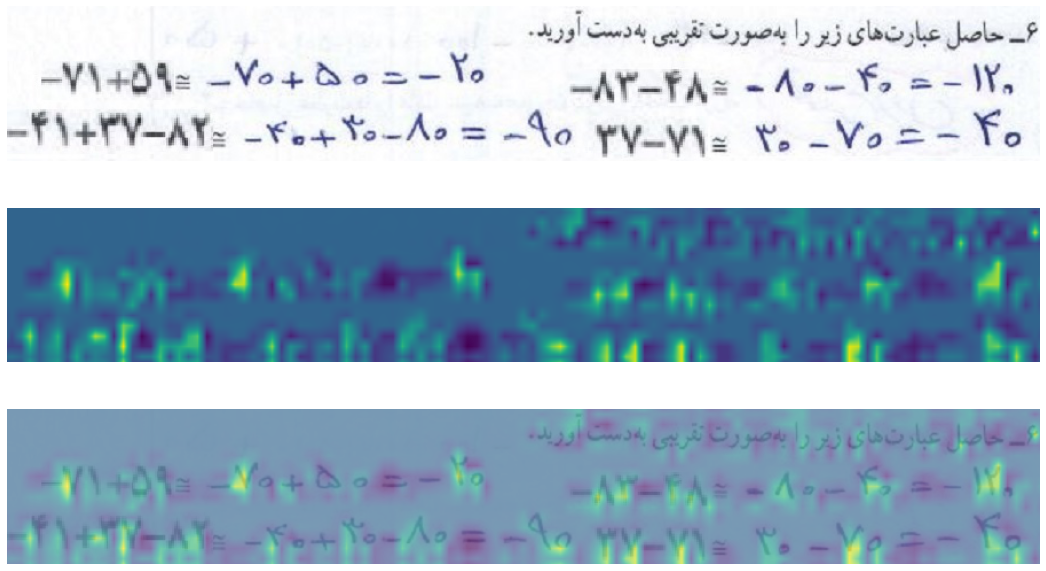

In [151]:
digit = 7
map = yHat[0][:,:,digit]
from skimage.transform import resize
map = resize(map, (x.shape[0], x.shape[1]))

img = image.load_img(fileName,color_mode='rgb')

fig, ax = plt.subplots(3,1)
fig.set_size_inches(18.5, 10.5)
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(map)
ax[1].axis('off')
ax[2].imshow(img, alpha=0.5)
ax[2].imshow(map, alpha=0.65) #, cmap='hot'
ax[2].axis('off')
plt.show()

fig.savefig('output.jpg', dpi=100)